# Density space PCO2 and fgco2 line plot

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import cftime

## Mixed layer

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

variables = ['mlotst']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gn = merge_variables(dd_gn)
# list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())
# dd_new_new_gn




--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [3]:
# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid={}
for name,item in dd_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item['mlotst']).assign_coords(**newcoords).chunk({'time':120})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(


['CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [4]:
variables = ['mlotst']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)

temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CESM2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon']

In [5]:
dd_mlotst = {**dd_gr, **dd_regrid}

## Zonal Average Mixed Layer

In [6]:
# for name, ds in dd_mlotst.items():
#     ds = ds.isel(time = slice(0,239))
#     ds = ds.sel(time=ds.time.dt.season=="JJA").mean('time',keep_attrs=True)
#     dd_mlotst[name] = ds
dd_annual = {}
dd_JJA = {}
for name, ds in dd_mlotst.items():
    ds = ds.isel(time = slice(0,239))
    ds_ann = ds.mean(['time', 'x'],keep_attrs=True)
    ds_JJA = ds.sel(time=ds.time.dt.season=="JJA").mean(['time', 'x'],keep_attrs=True)
    dd_annual[name] = ds_ann
    dd_JJA[name] = ds_JJA

## dd for `fgco2`

In [7]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').fgco2
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').fgco2
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').fgco2
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').fgco2
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').fgco2
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').fgco2
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').fgco2
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').fgco2
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').fgco2
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').fgco2
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').fgco2
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').fgco2
# A = xr.open_mfdataset('AREA.nc')

## Reassign Coords and area

In [8]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# dd_gr = merge_variables(dd_gr)

# temp={}
# for name,item in dd_gr.items():
#     #print(name)
#     #print(item.data_vars)
#     present = item.data_vars
#     if all(i in present for i in variables):
#         #print(name)
#         temp[name]=item
# dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

In [9]:
A = dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello

In [10]:
newcoords = {'x':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 180)>
 array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
        -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
        -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
        -19.5, -18.5, -17.5, -16.5,

In [11]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

## dd_x for PCO2

In [12]:
dd_x = {}
dd_x['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').mean('x', keep_attrs=True)
dd_x['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').mean('x', keep_attrs=True)
dd_x['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').mean('x', keep_attrs=True)
dd_x['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').mean('x', keep_attrs=True)
dd_x['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').mean('x', keep_attrs=True)
dd_x['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').mean('x', keep_attrs=True)
dd_x['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').mean('x', keep_attrs=True)
dd_x['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').mean('x', keep_attrs=True)
dd_x['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').mean('x', keep_attrs=True)
dd_x['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').mean('x', keep_attrs=True)
dd_x['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').mean('x', keep_attrs=True)
dd_x['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').mean('x', keep_attrs=True)

In [13]:
for name, ds in dd_x.items():
    # da = dd_x[name]
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    # ds['sigma2'] = gsw.sigma2(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])
    # ds['sigma1'] = gsw.sigma1(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)

In [14]:
PCO2_x = {}
for name, ds in dd_x.items():
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    PCO2_x[name] = results['pCO2_out']

## Select mixed layer values

In [15]:
ML = {}
ML_JJA = {}

for name, ds in dd_x.items():
    
    # ds = ds.mean('x', keep_attrs = True)
    if name == 'CESM2-WACCM.gr.historical.Omon' or name == 'CESM2.gr.historical.Omon' or name == 'CESM2-FV2.gr.historical.Omon' or name == 'CESM2-WACCM-FV2.gr.historical.Omon' or name == 'GFDL-ESM4.gr.historical.Omon' or name == 'MRI-ESM2-0.gr.historical.Omon' :
        ML[name] = ds.sel(lev = dd_annual[name].mlotst, method = 'nearest')
        ML_JJA[name] = ds.sel(lev = dd_JJA[name].mlotst, method = 'nearest')
    elif name != 'GFDL-CM4.gr.historical.Omon':
        ML[name] = ds.sel(lev = dd_annual[name], method = 'nearest')
        ML_JJA[name] = ds.sel(lev = dd_JJA[name], method = 'nearest')

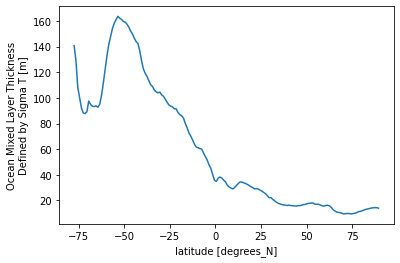

In [16]:
dd_JJA['CESM2-FV2.gr.historical.Omon'].mlotst.plot()

## Attempt to plot

In [17]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

### CESM2-FV2

/tmp/ipykernel_1021/3668632783.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


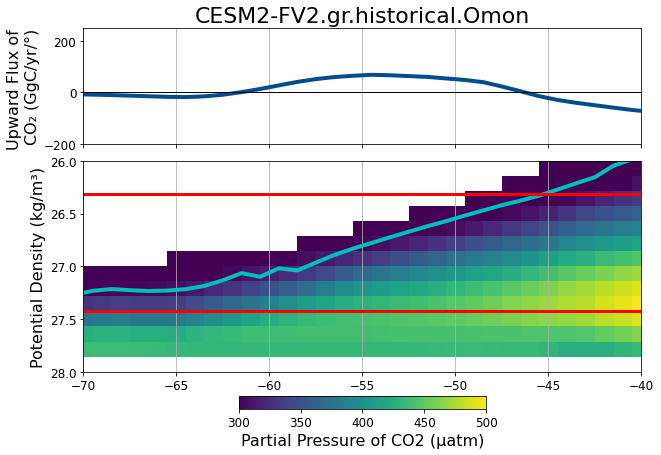

In [49]:
from xgcm import Grid

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)


name = 'CESM2-FV2.gr.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['CESM2-FV2.gr.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d,lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x['CESM2-FV2.gr.historical.Omon']

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.set_yticks([26, 26.5, 27, 27.5, 28])
ax2.grid(axis = 'x')
ax2.axhline(y=26.316, color = 'r', lw = 3)
ax2.axhline(y=27.427, color = 'r', lw = 3)

### CESM2-WACCM-FV2

/tmp/ipykernel_1021/3373983922.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


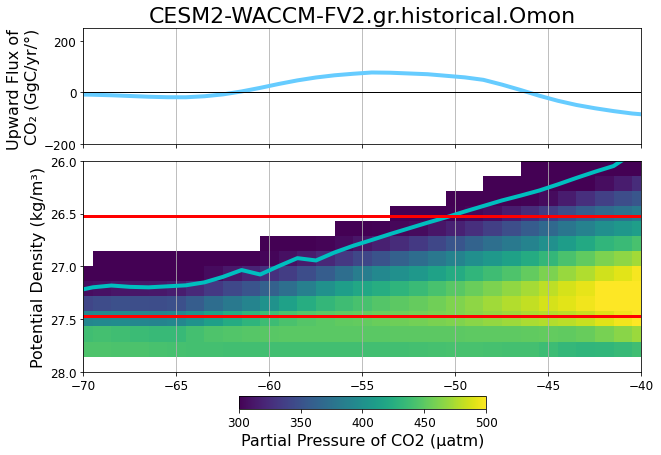

In [50]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'CESM2-WACCM-FV2.gr.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['CESM2-WACCM-FV2.gr.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.set_yticks([26, 26.5, 27, 27.5, 28])
ax2.grid(axis = 'x')
ax2.axhline(y=26.527, color = 'r', lw = 3)
ax2.axhline(y=27.474, color = 'r', lw = 3)

### CESM2-WACCM

/tmp/ipykernel_1021/3858314369.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


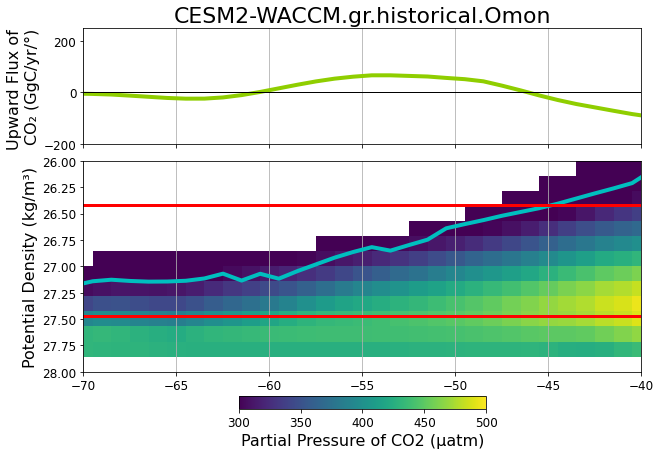

In [46]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'CESM2-WACCM.gr.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['CESM2-WACCM.gr.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize=22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.grid(axis = 'x')
ax2.axhline(y=26.421, color = 'r', lw = 3)
ax2.axhline(y=27.474, color = 'r', lw = 3)

### CESM2

/tmp/ipykernel_1021/2667036348.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


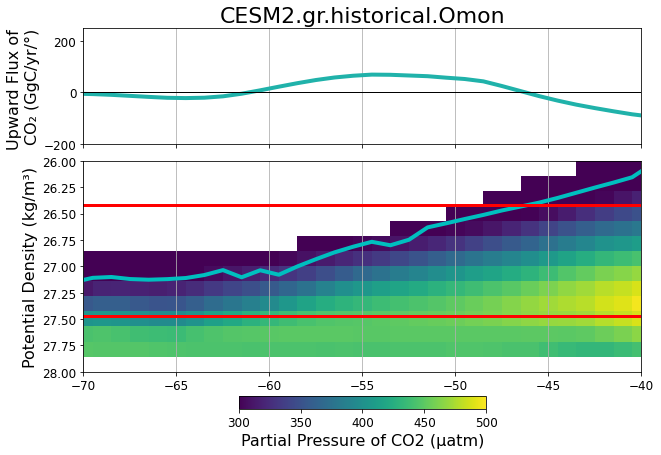

In [45]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'CESM2.gr.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['CESM2.gr.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.grid(axis = 'x')
ax2.axhline(y=26.421, color = 'r', lw = 3)
ax2.axhline(y=27.474, color = 'r', lw = 3)

### CNRM-ESM2-1

/tmp/ipykernel_1021/2055119520.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


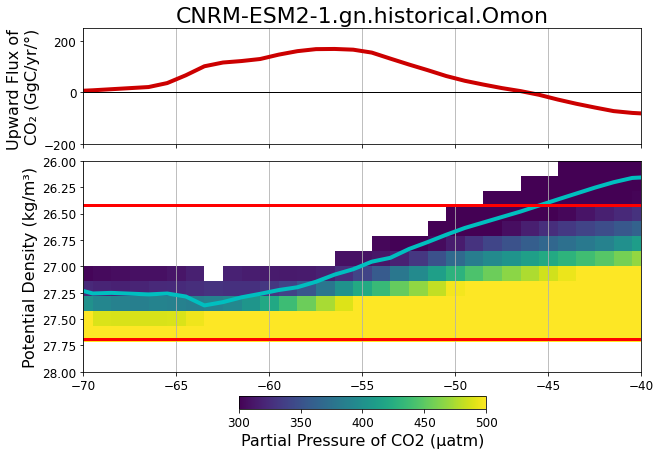

In [44]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'CNRM-ESM2-1.gn.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['CNRM-ESM2-1.gn.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.grid(axis = 'x')
ax2.axhline(y=26.421, color = 'r', lw = 3)
ax2.axhline(y=27.69, color = 'r', lw = 3)

### CanESM5-CanOE

/tmp/ipykernel_1021/3339285956.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


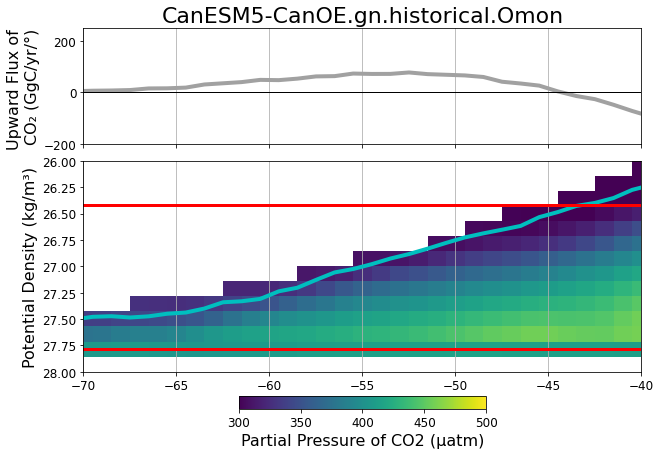

In [43]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'CanESM5-CanOE.gn.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['CanESM5-CanOE.gn.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.grid(axis = 'x')
ax2.axhline(y=26.421, color = 'r', lw = 3)
ax2.axhline(y=27.789, color = 'r', lw = 3)

### CanESM5

/tmp/ipykernel_1021/3272617989.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


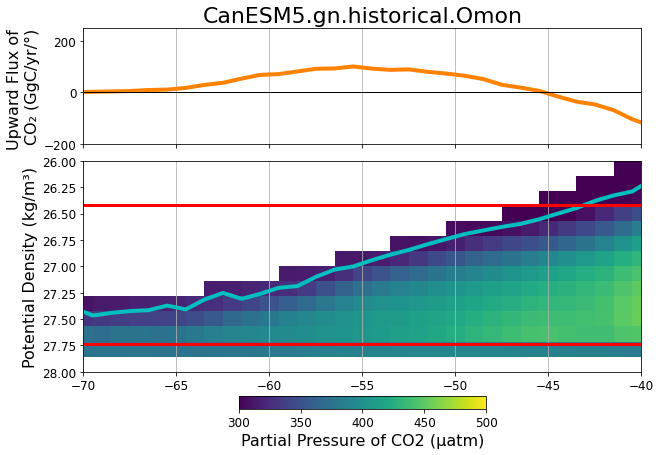

In [42]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'CanESM5.gn.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['CanESM5.gn.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.grid(axis = 'x')
ax2.axhline(y=26.421, color = 'r', lw = 3)
ax2.axhline(y=27.737, color = 'r', lw = 3)

### GFDL-CM4

/tmp/ipykernel_1021/417714359.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


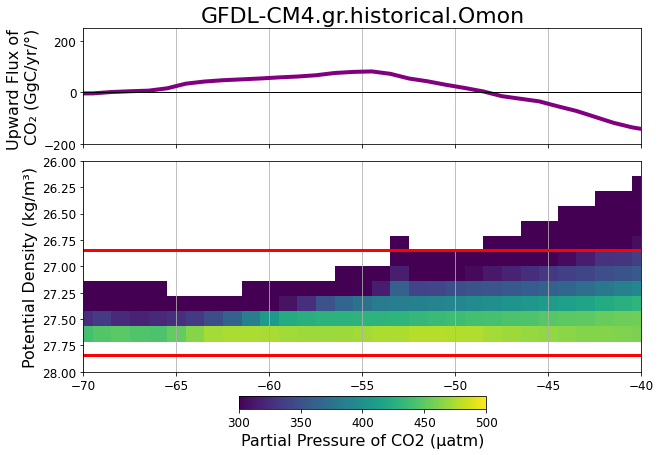

In [41]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'GFDL-CM4.gr.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['GFDL-CM4.gr.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
# ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.grid(axis = 'x')
ax2.axhline(y=26.842, color = 'r', lw = 3)
ax2.axhline(y=27.842, color = 'r', lw = 3)

### GFDL-ESM4

/tmp/ipykernel_1021/1111520215.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


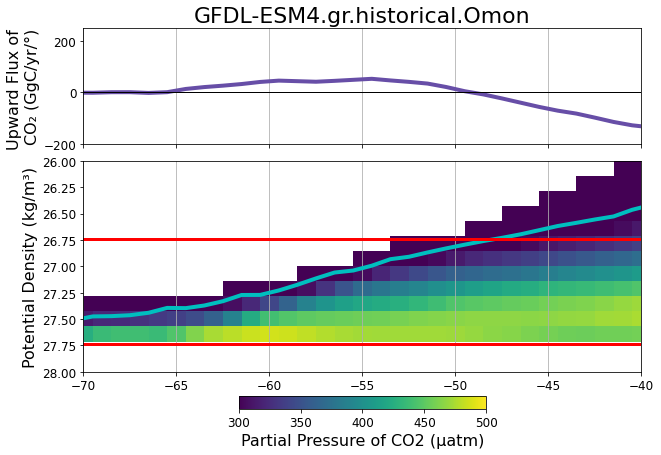

In [40]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'GFDL-ESM4.gr.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['GFDL-ESM4.gr.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.grid(axis = 'x')
ax2.axhline(y=26.737, color = 'r', lw = 3)
ax2.axhline(y=27.737, color = 'r', lw = 3)

### IPSL-CM6A-LR

/tmp/ipykernel_1021/1895422468.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


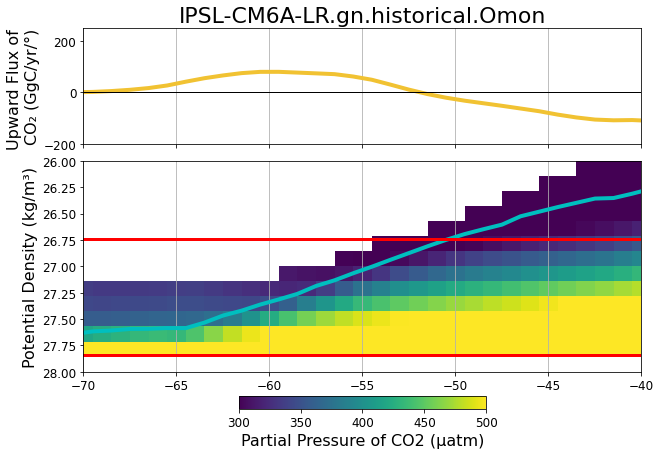

In [39]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'IPSL-CM6A-LR.gn.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['IPSL-CM6A-LR.gn.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.grid(axis = 'x')
ax2.axhline(y=26.737, color = 'r', lw = 3)
ax2.axhline(y=27.842, color = 'r', lw = 3)

### MRI-ESM2-0

/tmp/ipykernel_1021/149623739.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


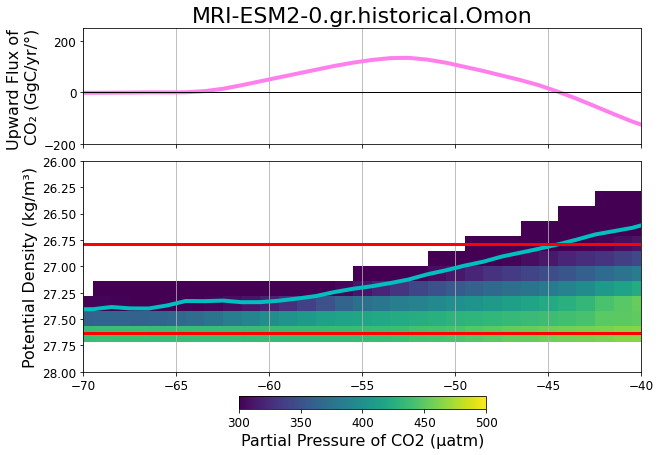

In [38]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'MRI-ESM2-0.gr.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['MRI-ESM2-0.gr.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')
ax2.grid(axis = 'x')
ax2.axhline(y=26.789, color = 'r', lw = 3)
ax2.axhline(y=27.632, color = 'r', lw = 3)

### UKESM1-0-LL

/tmp/ipykernel_1021/1414050346.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)


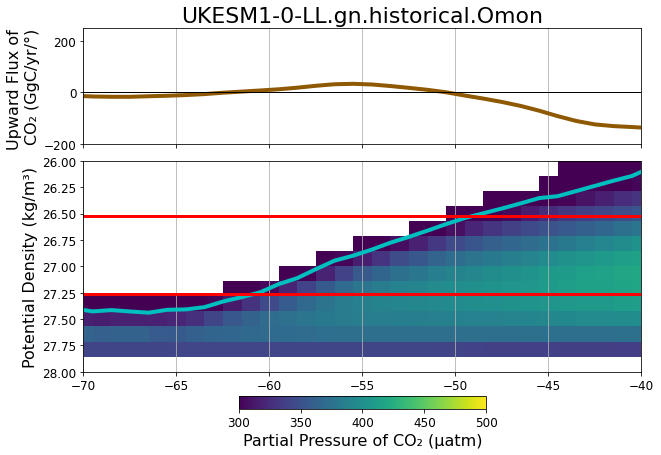

In [37]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28, 15)

fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((3,1), (0, 0))
plt.subplots_adjust(hspace=0.15)
ax.set_xticklabels([])

name = 'UKESM1-0-LL.gn.historical.Omon'

conversion = 3.1536e7 * 83.3
ds1 = dd['UKESM1-0-LL.gn.historical.Omon']
d = -1*ds1*A*conversion*12/1e9
d = d.mean(['x'],keep_attrs=True)
d

ax.plot(d.y, d, lw = 4, **model_kwargs[name])
ax.set_xlim([-70,-40])
ax.axhline(y=0, color = 'k', lw = 1)
ax.set_ylim([-200, 250])
ax.set_ylabel('Upward Flux of \nCO\u2082 (GgC/yr/\u00b0)')
ax.set_title(name, fontsize = 22)
ax.grid(axis = 'x')

ds = dd_x[name]

ax2 = plt.subplot2grid((3,1), (1, 0), rowspan = 2)
DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
conversion =  1e6/1035
results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

ppco2 = DIC.copy(data=results['pCO2_out'])
    
# plt.figure(figsize = [10,3])
    
ax2.set_xlim([-70,-40])


ax2.set_ylim([26, 28])
ax2.invert_yaxis()
    
im = ax2.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
ax2.grid(axis = 'x')
cbar = plt.colorbar(im, ax = ax2, orientation='horizontal', fraction = 0.05, pad = 0.1)
cbar.set_label('Partial Pressure of CO\u2082 (\u03BCatm)')
ax2.plot(ppco2['y'],ML_JJA[name].sigma0, color = 'c', lw = 4)
ax2.set_ylabel('Potential Density (kg/m\u00b3)')

ax2.axhline(y=26.526, color = 'r', lw = 3)
ax2.axhline(y=27.263, color = 'r', lw = 3)


In [145]:
# ML2 = {}
# ML_JJA2 = {}

for name, ds in PCO2_x.items():
    # if name == 'CESM2-WACCM.gr.historical.Omon' or name == 'CESM2.gr.historical.Omon' or name == 'CESM2-FV2.gr.historical.Omon' or name == 'CESM2-WACCM-FV2.gr.historical.Omon' or name == 'GFDL-ESM4.gr.historical.Omon' or name == 'MRI-ESM2-0.gr.historical.Omon' :
    #     ML[name] = ds.sel(lev = dd_annual[name].mlotst, method = 'nearest')
    #     ML_JJA[name] = ds.sel(lev = dd_JJA[name].mlotst, method = 'nearest')
    if name != 'GFDL-CM4.gr.historical.Omon':
        ML[name] = ds.sel(lev = dd_annual[name], method = 'nearest')
        ML_JJA[name] = ds.sel(lev = dd_JJA[name], method = 'nearest')

ValueError: 'x' not found in array dimensions ('y',)

In [146]:
PCO2_x['CESM2-FV2.gr.historical.Omon']

array([[         nan,          nan,          nan, ..., 282.22020359,
        282.73299019, 282.96751432],
       [         nan,          nan,          nan, ..., 282.27914926,
        282.77596204, 283.00690519],
       [         nan,          nan,          nan, ..., 282.58017228,
        283.0355108 , 283.25394906],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])